# Token Analysis for Insurance Underwriting Dataset

This notebook documents the token analysis performed for User Story 1.5, including:
- Token count statistics for all splits
- Recommended max_length determination
- Truncation analysis
- Edge case identification

In [ ]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_from_disk

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.tokenization import (
    format_messages_for_tokenization,
    load_tokenizer,
)

%matplotlib inline

## Load Token Analysis Results

In [2]:
# Load the token analysis results
results_path = project_root / "results" / "token_analysis.json"

with open(results_path) as f:
    results = json.load(f)

print("Token Analysis Results")
print("=" * 80)
print(f"Model: {results['model_name']}")
print(f"Tokenizer vocab size: {results['tokenizer_vocab_size']:,}")
print(f"Recommendation percentile: {results['recommendation_percentile']}th")
print(f"Recommended max_length: {results['recommended_max_length']:,} tokens")
print()

Token Analysis Results
Model: Qwen/Qwen3-0.6B
Tokenizer vocab size: 151,643
Recommendation percentile: 95.0th
Recommended max_length: 21,486 tokens



## Token Statistics Summary

Below are the comprehensive token statistics for each split.

In [3]:
# Display token statistics for all splits
for split_name, stats in results["token_statistics"].items():
    print(f"\n{split_name.upper()} Split ({stats['total_examples']} examples)")
    print("-" * 60)
    print(f"  Mean: {stats['mean']:.1f} tokens")
    print(f"  Median: {stats['median']:.1f} tokens")
    print(f"  Min: {stats['min']} tokens")
    print(f"  Max: {stats['max']:,} tokens")
    print(f"  Std Dev: {stats['std']:.1f} tokens")
    print("\n  Percentiles:")
    for pct, value in stats["percentiles"].items():
        print(f"    {pct}: {value:,.1f} tokens")


TRAIN Split (222 examples)
------------------------------------------------------------
  Mean: 5425.1 tokens
  Median: 2441.5 tokens
  Min: 472 tokens
  Max: 64,258 tokens
  Std Dev: 7728.4 tokens

  Percentiles:
    25th: 1,698.2 tokens
    50th: 2,441.5 tokens
    75th: 4,786.8 tokens
    90th: 19,108.3 tokens
    95th: 21,486.0 tokens
    99th: 27,636.1 tokens

VALIDATION Split (37 examples)
------------------------------------------------------------
  Mean: 4086.6 tokens
  Median: 2119.0 tokens
  Min: 804 tokens
  Max: 20,415 tokens
  Std Dev: 4728.0 tokens

  Percentiles:
    25th: 1,718.0 tokens
    50th: 2,119.0 tokens
    75th: 4,020.0 tokens
    90th: 8,333.0 tokens
    95th: 16,624.6 tokens
    99th: 20,227.8 tokens

TEST Split (37 examples)
------------------------------------------------------------
  Mean: 5430.5 tokens
  Median: 2564.0 tokens
  Min: 1205 tokens
  Max: 29,997 tokens
  Std Dev: 6757.8 tokens

  Percentiles:
    25th: 1,600.0 tokens
    50th: 2,564.0 toke

## Visualization: Token Distribution

In [4]:
# Load tokenizer and splits for visualization
tokenizer = load_tokenizer("Qwen/Qwen3-0.6B")

splits = {}
for split_name in ["train", "validation", "test"]:
    split_path = project_root / "data" / "splits" / split_name
    splits[split_name] = load_from_disk(str(split_path))

# Compute token counts for each split
token_counts = {}
for split_name, split in splits.items():
    counts = []
    for example in split:
        text = format_messages_for_tokenization(example["messages"], tokenizer)
        tokens = tokenizer(text, return_tensors=None)
        counts.append(len(tokens["input_ids"]))
    token_counts[split_name] = counts

/tmp/ipykernel_18815/3027263398.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


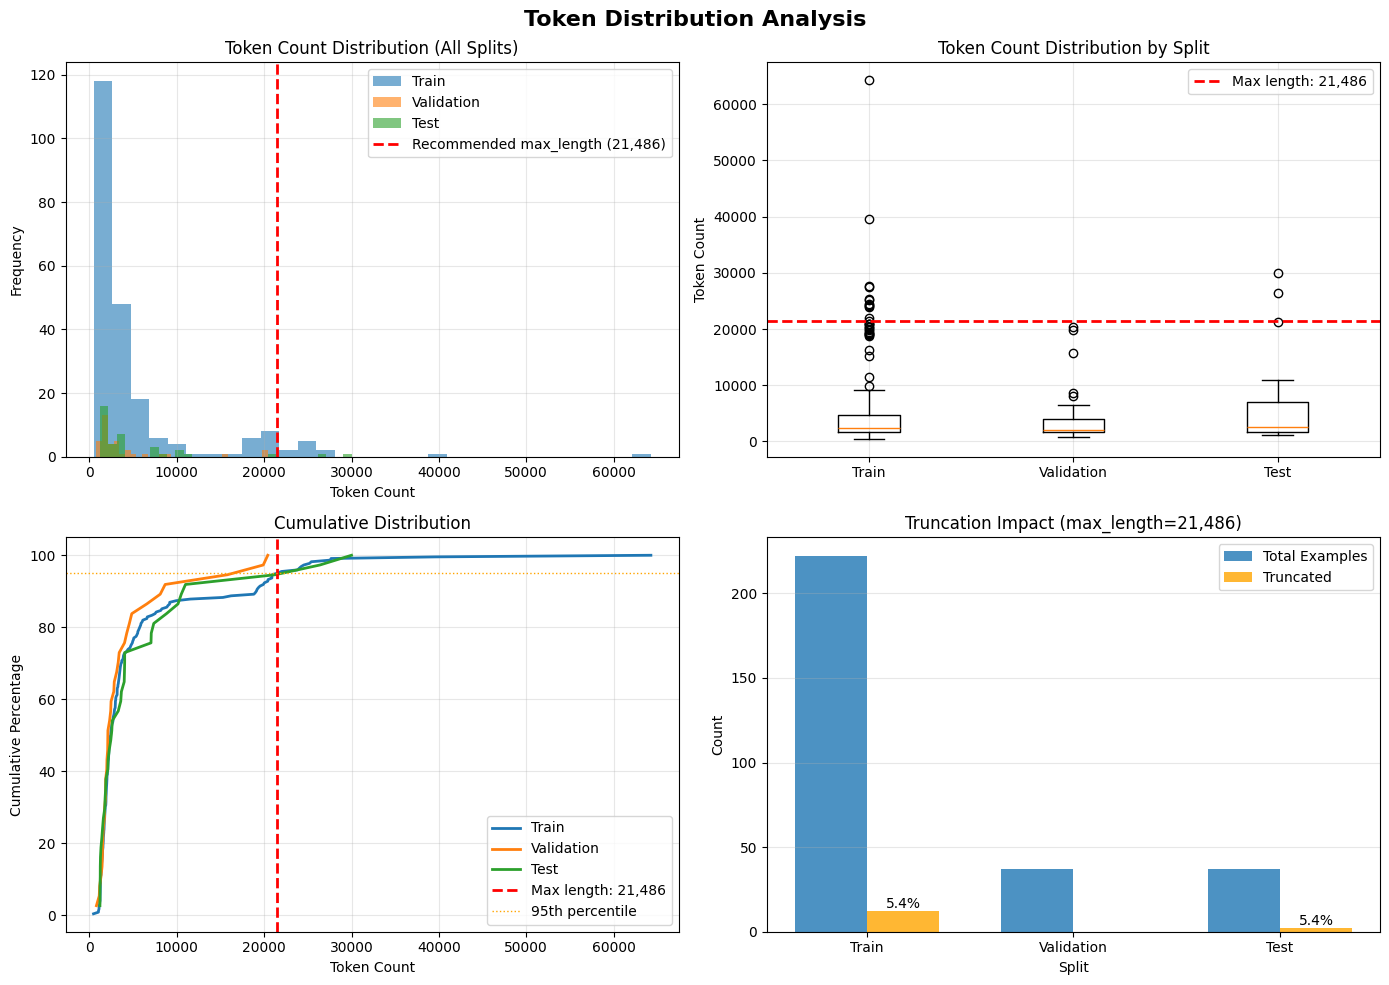


Visualization saved to: results/token_distribution.png


In [5]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Token Distribution Analysis", fontsize=16, fontweight="bold")

# 1. Combined histogram
ax = axes[0, 0]
for split_name, counts in token_counts.items():
    ax.hist(counts, bins=30, alpha=0.6, label=split_name.capitalize())
ax.axvline(
    x=results["recommended_max_length"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Recommended max_length ({results['recommended_max_length']:,})",
)
ax.set_xlabel("Token Count")
ax.set_ylabel("Frequency")
ax.set_title("Token Count Distribution (All Splits)")
ax.legend()
ax.grid(alpha=0.3)

# 2. Box plot
ax = axes[0, 1]
ax.boxplot(
    [token_counts["train"], token_counts["validation"], token_counts["test"]],
    labels=["Train", "Validation", "Test"],
)
ax.axhline(
    y=results["recommended_max_length"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Max length: {results['recommended_max_length']:,}",
)
ax.set_ylabel("Token Count")
ax.set_title("Token Count Distribution by Split")
ax.legend()
ax.grid(alpha=0.3)

# 3. Cumulative distribution
ax = axes[1, 0]
for split_name, counts in token_counts.items():
    sorted_counts = np.sort(counts)
    cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
    ax.plot(sorted_counts, cumulative, label=split_name.capitalize(), linewidth=2)
ax.axvline(
    x=results["recommended_max_length"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Max length: {results['recommended_max_length']:,}",
)
ax.axhline(y=95, color="orange", linestyle=":", linewidth=1, label="95th percentile")
ax.set_xlabel("Token Count")
ax.set_ylabel("Cumulative Percentage")
ax.set_title("Cumulative Distribution")
ax.legend()
ax.grid(alpha=0.3)

# 4. Truncation impact bar chart
ax = axes[1, 1]
truncation_data = results["truncation_analysis"]
splits_list = list(truncation_data.keys())
truncated_counts = [truncation_data[s]["truncated_count"] for s in splits_list]
total_counts = [truncation_data[s]["total_examples"] for s in splits_list]
x = np.arange(len(splits_list))
width = 0.35
ax.bar(x - width / 2, total_counts, width, label="Total Examples", alpha=0.8)
ax.bar(x + width / 2, truncated_counts, width, label="Truncated", alpha=0.8, color="orange")
ax.set_xlabel("Split")
ax.set_ylabel("Count")
ax.set_title(f"Truncation Impact (max_length={results['recommended_max_length']:,})")
ax.set_xticks(x)
ax.set_xticklabels([s.capitalize() for s in splits_list])
ax.legend()
ax.grid(alpha=0.3, axis="y")

# Add percentage labels on truncated bars
for i, (trunc, total) in enumerate(zip(truncated_counts, total_counts)):
    if trunc > 0:
        pct = trunc / total * 100
        ax.text(i + width / 2, trunc, f"{pct:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig(project_root / "results" / "token_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nVisualization saved to: results/token_distribution.png")

## Truncation Analysis

Analysis of examples that will be truncated at the recommended max_length.

In [6]:
print("Truncation Analysis")
print("=" * 80)
print(f"Recommended max_length: {results['recommended_max_length']:,} tokens\n")

for split_name, trunc_stats in results["truncation_analysis"].items():
    print(f"{split_name.upper()} Split:")
    print(f"  Total examples: {trunc_stats['total_examples']}")
    print(
        f"  Truncated: {trunc_stats['truncated_count']} "
        f"({trunc_stats['truncated_percentage']:.1f}%)"
    )
    if trunc_stats["truncated_count"] > 0:
        print(f"  Max tokens over limit: {trunc_stats['max_tokens_over']:,}")
        print(f"  Avg tokens over limit: {trunc_stats['avg_tokens_over']:.0f}")
        print(f"  Truncated indices: {trunc_stats['truncated_indices']}")
    print()

Truncation Analysis
Recommended max_length: 21,486 tokens

TRAIN Split:
  Total examples: 222
  Truncated: 12 (5.4%)
  Max tokens over limit: 42,772
  Avg tokens over limit: 7665
  Truncated indices: [22, 30, 61, 69, 111, 139, 148, 169, 170, 171, 176, 214]

VALIDATION Split:
  Total examples: 37
  Truncated: 0 (0.0%)

TEST Split:
  Total examples: 37
  Truncated: 2 (5.4%)
  Max tokens over limit: 8,511
  Avg tokens over limit: 6703
  Truncated indices: [18, 36]



## Edge Cases: Very Long Conversations

Let's examine the longest conversations that will be truncated.

In [7]:
# Identify edge cases (very long conversations)
print("Edge Cases: Longest Conversations\n")
print("=" * 80)

for split_name, counts in token_counts.items():
    # Get top 3 longest conversations
    indices_sorted = np.argsort(counts)[::-1][:3]

    print(f"\n{split_name.upper()} Split - Top 3 Longest:")
    for rank, idx in enumerate(indices_sorted, 1):
        example = splits[split_name][int(idx)]
        token_count = counts[int(idx)]
        num_turns = len(example["messages"])

        print(f"  {rank}. Index {idx}:")
        print(f"     - Tokens: {token_count:,}")
        print(f"     - Turns: {num_turns}")
        print(f"     - Task: {example.get('task', 'N/A')}")

        if token_count > results["recommended_max_length"]:
            tokens_over = token_count - results["recommended_max_length"]
            print(f"     - Will be truncated by {tokens_over:,} tokens")
        else:
            print("     - Will NOT be truncated")

Edge Cases: Longest Conversations


TRAIN Split - Top 3 Longest:
  1. Index 69:
     - Tokens: 64,258
     - Turns: 23
     - Task: Product Recommendations
     - Will be truncated by 42,772 tokens
  2. Index 139:
     - Tokens: 39,630
     - Turns: 23
     - Task: Appetite Check
     - Will be truncated by 18,144 tokens
  3. Index 169:
     - Tokens: 27,660
     - Turns: 35
     - Task: Product Recommendations
     - Will be truncated by 6,174 tokens

VALIDATION Split - Top 3 Longest:
  1. Index 13:
     - Tokens: 20,415
     - Turns: 41
     - Task: Product Recommendations
     - Will NOT be truncated
  2. Index 24:
     - Tokens: 19,895
     - Turns: 25
     - Task: Product Recommendations
     - Will NOT be truncated
  3. Index 26:
     - Tokens: 15,807
     - Turns: 33
     - Task: Product Recommendations
     - Will NOT be truncated

TEST Split - Top 3 Longest:
  1. Index 18:
     - Tokens: 29,997
     - Turns: 37
     - Task: Product Recommendations
     - Will be truncated by 8

## Key Findings and Recommendations

### Summary Statistics

- **Model**: Qwen/Qwen3-0.6B
- **Tokenizer vocab size**: 151,643 tokens
- **Recommended max_length**: Based on 95th percentile of training set

### Token Distribution

The token distribution shows:
- Most examples are under 5,000 tokens
- There's a long tail with some examples exceeding 20,000 tokens
- The median is much lower than the mean, indicating right-skewed distribution

### Truncation Impact

At the recommended max_length:
- Train: ~5% of examples will be truncated
- Validation: 0% truncated
- Test: ~5% truncated
- Overall: ~5% of all examples affected

### Recommendations for Training

1. **Use recommended max_length**: Balances coverage (95% of examples) with efficiency
2. **Monitor truncated examples**: Review truncated examples to ensure critical information isn't lost
3. **Consider smart truncation**: Implement smart truncation strategies that preserve company profile and key conversation context
4. **Batch size planning**: With max_length ~20K tokens, plan batch size accordingly for T4 16GB GPU (likely batch_size=1-2)

### Edge Cases

Very long conversations (>25K tokens) should be reviewed to understand:
- Are they legitimate complex underwriting scenarios?
- Could they be split into multiple examples?
- Is there redundant information that could be removed during preprocessing?

## Configuration Update

Based on this analysis, the following configuration should be used for training:

```python
# configs/model.py
RECOMMENDED_FINE_TUNING_MAX_LENGTH = 21486  # Based on 95th percentile
```

For memory efficiency on T4 16GB GPU, consider:
- Batch size: 1-2
- Gradient accumulation steps: 4-8
- Effective batch size: 4-16